<a href="https://colab.research.google.com/github/UvanShankar/SkinCancer_Fastai_Api/blob/master/skin_cancer_detection_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading the dataset

First of all, let's download the dataset. Dataset which we are going to analyze is a kaggle dataset called "Skin Cancer MNIST" which contains 10015 dermatoscopic images of all important diagnostic categories of pigmented skin lesions:  Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc). In order to download the dataset, we use Kaggle API. Please check [here](https://github.com/Kaggle/kaggle-api) for more information regarding how to install and use the API.

In [0]:
!pip install -U -q kaggle
! mkdir ~/.kaggle
!ls
from google.colab import files
files.upload()

mkdir: cannot create directory ‘/root/.kaggle’: File exists
sample_data


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"uvanshankar","key":"13c264b0a2b9a022ab375f2bdd390890"}'}

In [0]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets list -s cancer

ref                                                   title                                           size  lastUpdated          downloadCount  
----------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
xiaotawkaggle/inhibitors                              Cancer Inhibitors                              104MB  2019-11-14 06:48:37           3178  
kmader/skin-cancer-mnist-ham10000                     Skin Cancer MNIST: HAM10000                      5GB  2018-09-20 20:36:13          25619  
piotrgrabo/breastcancerproteomes                      Breast Cancer Proteomes                          5MB  2019-11-14 05:15:12           8464  
loveall/cervical-cancer-risk-classification           Cervical Cancer Risk Classification              9KB  2017-08-31 01:02:22          12889  
uciml/breast-cancer-wisconsin-data                    Breast Cancer Wisconsin (Diagnostic) Data Set   49KB  2016-09-25 10:49:04   

In [0]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p data/

100% 5.20G/5.20G [01:52<00:00, 43.5MB/s]
100% 5.20G/5.20G [01:52<00:00, 49.6MB/s]


After downloading the dataset, we unzip that into the data folder.

In [0]:
!unzip data/skin-cancer-mnist-ham10000.zip -d data/

Streaming output truncated to the last 5000 lines.
  inflating: data/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: data/ham10000_images_part_2/ISIC_002

In [0]:
! chmod 600 data/HAM10000_metadata.csv

In [0]:
%cd data/

!mv  -v HAM10000_images_part_1/* HAM10000_images_part_2/

!ls
%cd ..

Streaming output truncated to the last 5000 lines.
renamed 'HAM10000_images_part_1/ISIC_0024312.jpg' -> 'HAM10000_images_part_2/ISIC_0024312.jpg'
renamed 'HAM10000_images_part_1/ISIC_0024313.jpg' -> 'HAM10000_images_part_2/ISIC_0024313.jpg'
renamed 'HAM10000_images_part_1/ISIC_0024314.jpg' -> 'HAM10000_images_part_2/ISIC_0024314.jpg'
renamed 'HAM10000_images_part_1/ISIC_0024315.jpg' -> 'HAM10000_images_part_2/ISIC_0024315.jpg'
renamed 'HAM10000_images_part_1/ISIC_0024316.jpg' -> 'HAM10000_images_part_2/ISIC_0024316.jpg'
renamed 'HAM10000_images_part_1/ISIC_0024317.jpg' -> 'HAM10000_images_part_2/ISIC_0024317.jpg'
renamed 'HAM10000_images_part_1/ISIC_0024318.jpg' -> 'HAM10000_images_part_2/ISIC_0024318.jpg'
renamed 'HAM10000_images_part_1/ISIC_0024319.jpg' -> 'HAM10000_images_part_2/ISIC_0024319.jpg'
renamed 'HAM10000_images_part_1/ISIC_0024320.jpg' -> 'HAM10000_images_part_2/ISIC_0024320.jpg'
renamed 'HAM10000_images_part_1/ISIC_0024321.jpg' -> 'HAM10000_images_part_2/ISIC_0024321.jpg'

## Setup and data preparation

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


First we put dataset''s metadata into a pandas dataframe. This dataframe later we be used in order to create a databunch from images.  

In [0]:
df = pd.read_csv("data/HAM10000_metadata.csv")
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Next we map dx column to lesion types:

In [0]:
# Categories of the diferent diseases
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df['lesion'] = df.dx.map(lesion_type_dict)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,lesion
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis


Here we examine the number of images in each of the seven categories of skin lesions.
It is clear that this dataset is imbalanced, with 6705 samples in 'Melanocyctic nevi' class and only 115 'Dermatofibroma' samples.

In [0]:
print(df.lesion.value_counts())

Melanocytic nevi        6705
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesions         142
Dermatofibroma           115
Name: lesion, dtype: int64


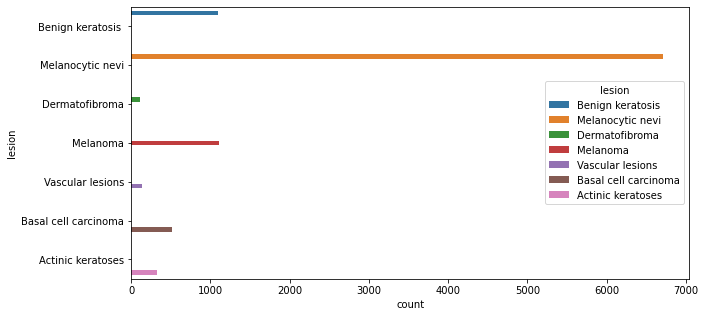

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='lesion',data=df, hue="lesion",ax=ax1)

In order to alleviate the class imabalance issue, we apply random undersampling to classes with over 200 samples:

## Undersampling

In [0]:
num_sample = 200

df_df = df.loc[df['dx'] == "df"][0:115]
df_vasc = df.loc[df['dx'] == "vasc"][0:142]
df_akiec = (df.loc[df['dx'] == "akiec"]).sample(num_sample)
df_bcc = df.loc[df['dx'] == "bcc"][0:num_sample].sample(num_sample)
df_bkl = df.loc[df['dx'] == "bkl"][0:num_sample].sample(num_sample)
df_mel = df.loc[df['dx'] == "mel"][0:num_sample].sample(num_sample)
df_nv = df.loc[df['dx'] == "nv"][0:num_sample].sample(num_sample)

df = pd.concat([df_akiec, df_bcc, df_bkl, df_df, df_mel, df_nv, df_vasc])
df = shuffle(df)

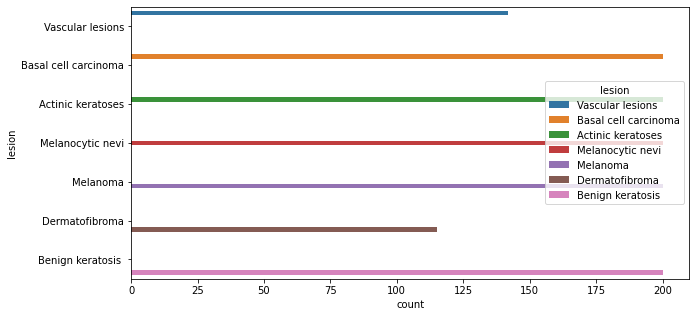

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='lesion',data=df, hue="lesion",ax=ax1)

Next we create an ImageDataBunch object from sampled dataset and apply common data augmentations to this dataset. We also normalize this dataset using ImageNet stats.

## Loading the data

In [0]:
tfms = get_transforms(flip_vert=True)
data = ImageDataBunch.from_df("data/HAM10000_images_part_2/", df, fn_col=1, suffix='.jpg', label_col=7, ds_tfms=tfms, size=224, bs=16)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (1006 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Basal cell carcinoma,Vascular lesions,Actinic keratoses,Actinic keratoses,Melanocytic nevi
Path: data/HAM10000_images_part_2;

Valid: LabelList (251 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Basal cell carcinoma,Melanocytic nevi,Dermatofibroma,Vascular lesions,Melanocytic nevi
Path: data/HAM10000_images_part_2;

Test: None

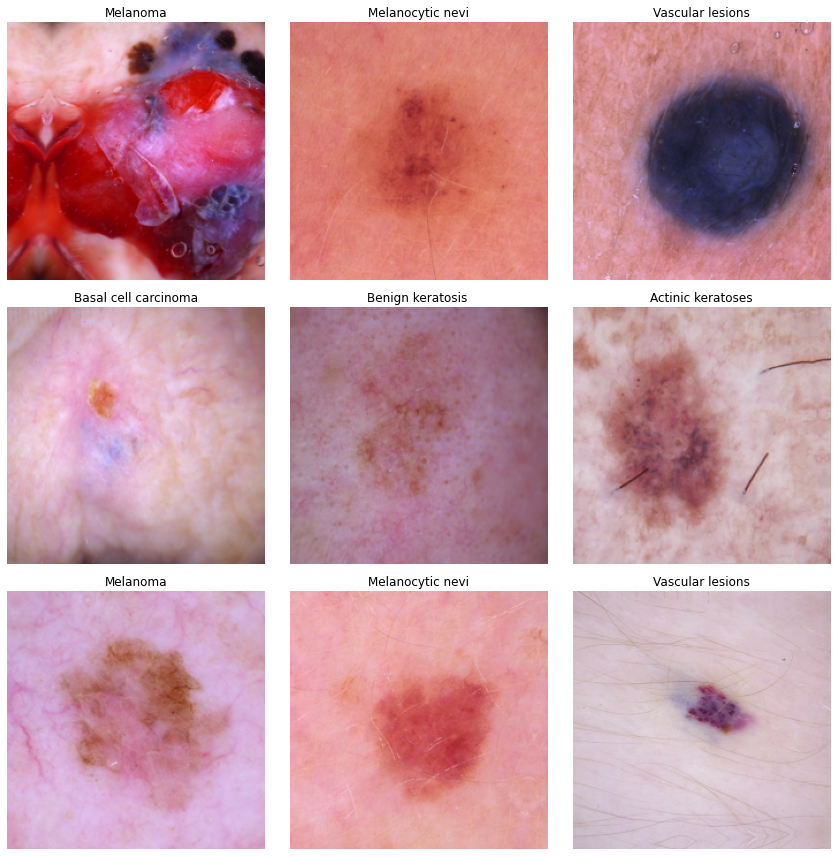

In [0]:
data.show_batch(rows=3)

## Model training and evaluation

Now we create a Learner object using a freezed pretrained densenet169 architecture:

In [0]:
learner = cnn_learner(data, models.densenet169, metrics=[accuracy, FBeta(average='macro')], model_dir="/content/")
learner.loss_func = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/checkpoints/densenet169-b2777c0a.pth


In [0]:
!ls

data  kaggle.json  sample_data


Before starting the training process, let's find the optimum learning rate using learning rate finder.
The plot shows that the steepest decrease in the loss value happens when learning rate is around 1e-03 value.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


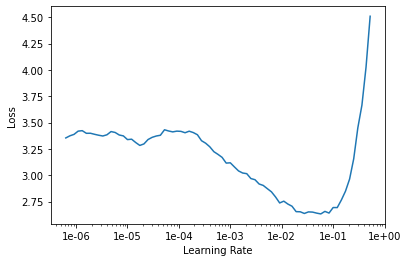

In [0]:
learner.lr_find()
learner.recorder.plot()

Now we train the model using the optimum learning rate. We also save the best model according to the accuracy of each epoch. Later we use this file to productionize our classifier:

In [0]:
learner.fit_one_cycle(30, 1e-3, callbacks=[SaveModelCallback(learner, every='improvement', monitor='accuracy', name='model_best')])

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.789321,1.753158,0.414343,0.398364,00:40
1,2.050324,1.091648,0.585657,0.569724,00:38
2,1.627320,0.849274,0.693227,0.675100,00:38
3,1.273679,0.791625,0.705179,0.695850,00:37
4,1.032528,0.683265,0.756972,0.751204,00:37
5,0.918302,0.721111,0.752988,0.740346,00:36
6,0.799001,0.652675,0.776892,0.773457,00:36
7,0.698792,0.725970,0.784861,0.775403,00:36
8,0.656010,0.735037,0.768924,0.775524,00:36
9,0.609197,0.605970,0.792829,0.789642,00:36


Better model found at epoch 0 with accuracy value: 0.41434264183044434.
Better model found at epoch 1 with accuracy value: 0.5856573581695557.
Better model found at epoch 2 with accuracy value: 0.6932271122932434.
Better model found at epoch 3 with accuracy value: 0.7051792740821838.
Better model found at epoch 4 with accuracy value: 0.7569721341133118.
Better model found at epoch 6 with accuracy value: 0.7768924236297607.
Better model found at epoch 7 with accuracy value: 0.7848605513572693.
Better model found at epoch 9 with accuracy value: 0.7928286790847778.
Better model found at epoch 11 with accuracy value: 0.8167330622673035.
Better model found at epoch 12 with accuracy value: 0.8525896668434143.
Better model found at epoch 17 with accuracy value: 0.8685259222984314.
Better model found at epoch 18 with accuracy value: 0.8764940500259399.
Better model found at epoch 20 with accuracy value: 0.9003984332084656.


As you can see, the best model found at epoxh 19 and the with accuracy of around %91.2 and f-measure of %91.7

## Model interpretation

In [0]:
learner = learner.load("model_best")

In [0]:
learner.export()

In [0]:
learner.export()

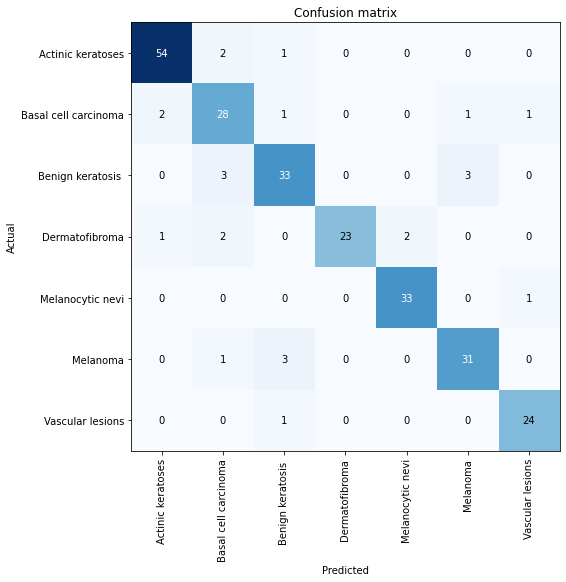

In [0]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(10,8))

In [0]:
interp.most_confused()

[('Melanoma', 'Basal cell carcinoma', 6),
 ('Benign keratosis ', 'Melanoma', 5),
 ('Actinic keratoses', 'Basal cell carcinoma', 3),
 ('Basal cell carcinoma', 'Benign keratosis ', 3),
 ('Dermatofibroma', 'Melanocytic nevi', 3),
 ('Melanoma', 'Benign keratosis ', 3),
 ('Actinic keratoses', 'Dermatofibroma', 2),
 ('Basal cell carcinoma', 'Actinic keratoses', 2),
 ('Vascular lesions', 'Benign keratosis ', 2),
 ('Actinic keratoses', 'Benign keratosis ', 1),
 ('Benign keratosis ', 'Actinic keratoses', 1),
 ('Dermatofibroma', 'Actinic keratoses', 1),
 ('Dermatofibroma', 'Basal cell carcinoma', 1)]

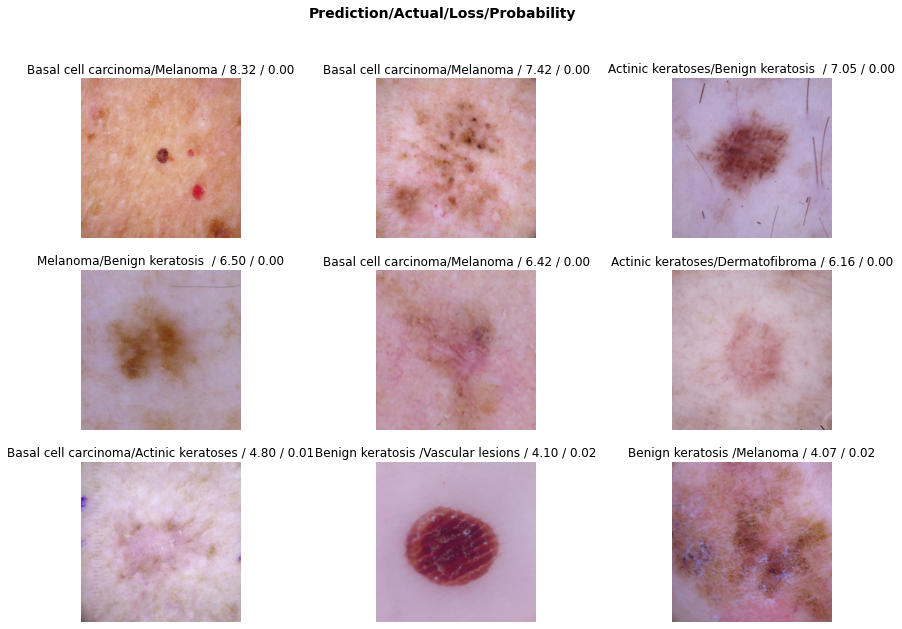

In [0]:
interp.plot_top_losses(9, figsize=(15,10), heatmap=False)

In [0]:
#from fastai import *
from fastai.vision import *
#from fastai.callbacks import *

#learner = cnn_learner(data, models.densenet169, metrics=[accuracy, FBeta(average='macro')], model_dir="../models/")

learn  = load_learner("","export.pkl")

In [0]:
img = open_image('/content/data/HAM10000_images_part_2/ISIC_0027419.jpg')
img
max(learn.predict(img)[2])


tensor(0.9867)

In [0]:
data.classes[learn.predict(img)[1]]


/content


In [0]:
p=['Actinic keratoses',
 'Basal cell carcinoma',
 'Benign keratosis ',
 'Dermatofibroma',
 'Melanocytic nevi',
 'Melanoma',
 'Vascular lesions']

In [0]:
p[learn.predict(img)[1]]

'Benign keratosis '